# 6.6 使用预训练好的卷积网络

**Daitu：2505131775@qq.com**

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
## 导入本章所需要的模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import cv2

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms
from PIL import Image

In [3]:
## 导入预训练好的VGG16网络
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### 获取中间特征进行可视化

单张图像，利用VGG16获取一些特定层的输出特征，用于可视化


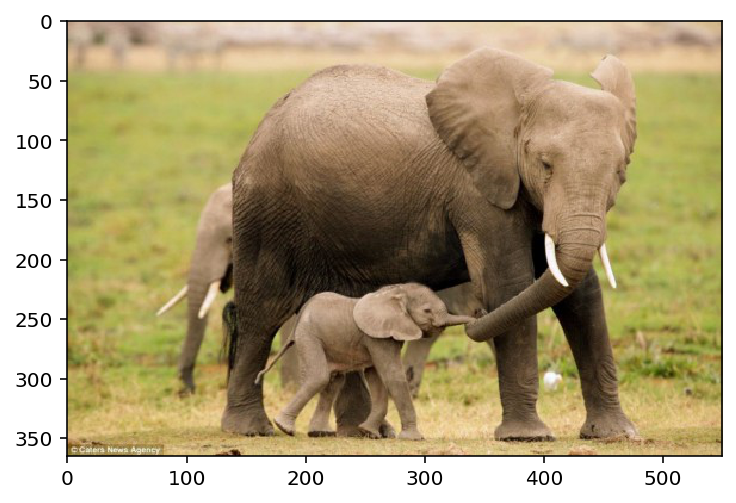

In [4]:
## 读取一张图片,并对其进行可视化
im = Image.open("data/chap6/大象.jpg")
imarray = np.asarray(im) / 255.0
plt.figure()
plt.imshow(imarray)
plt.show()

In [5]:
imarray.shape

(365, 550, 3)

In [6]:
## 对一张图像处理为vgg16网络可以处理的形式
data_transforms = transforms.Compose([
    transforms.Resize((224,224)),# 重置图像分辨率
    transforms.ToTensor(),# 转化为张量并归一化至[0-1]
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_im = data_transforms(im).unsqueeze(0)
print("input_im.shape:",input_im.shape)

input_im.shape: torch.Size([1, 3, 224, 224])


In [7]:
## 使用钩子获取分类层的2个特征
## 定义一个辅助函数，来获取指定层名称的特征
activation = {} ## 保存不同层的输出
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [8]:
## 获取中间的卷积后的图像特征
vgg16.eval()
##  第四层，经过第一次最大值池化
vgg16.features[4].register_forward_hook(get_activation("maxpool1"))
_ = vgg16(input_im)
maxpool1 = activation["maxpool1"]
print("获取特征的尺寸为:",maxpool1.shape)

获取特征的尺寸为: torch.Size([1, 64, 112, 112])


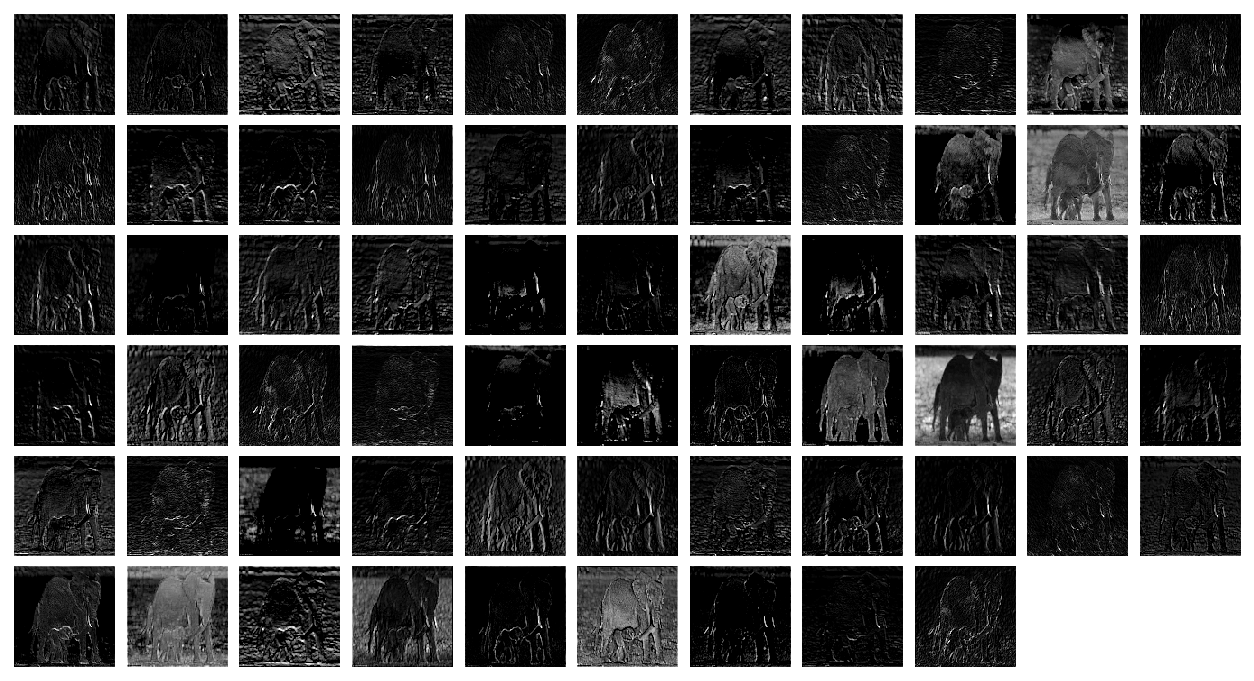

In [9]:
## 对中间层进行可视化,可视化64个特征映射
plt.figure(figsize=(11,6))
for ii in range(maxpool1.shape[1]):
    ## 可视化每张手写体
    plt.subplot(6,11,ii+1)
    plt.imshow(maxpool1.data.numpy()[0,ii,:,:],cmap="gray")
    plt.axis("off")
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [10]:
## 获取更深层次的卷积后的图像特征
vgg16.eval()
vgg16.features[21].register_forward_hook(get_activation("layer21_conv"))
_ = vgg16(input_im)
layer21_conv = activation["layer21_conv"]
print("获取特征的尺寸为:",layer21_conv.shape)

获取特征的尺寸为: torch.Size([1, 512, 28, 28])


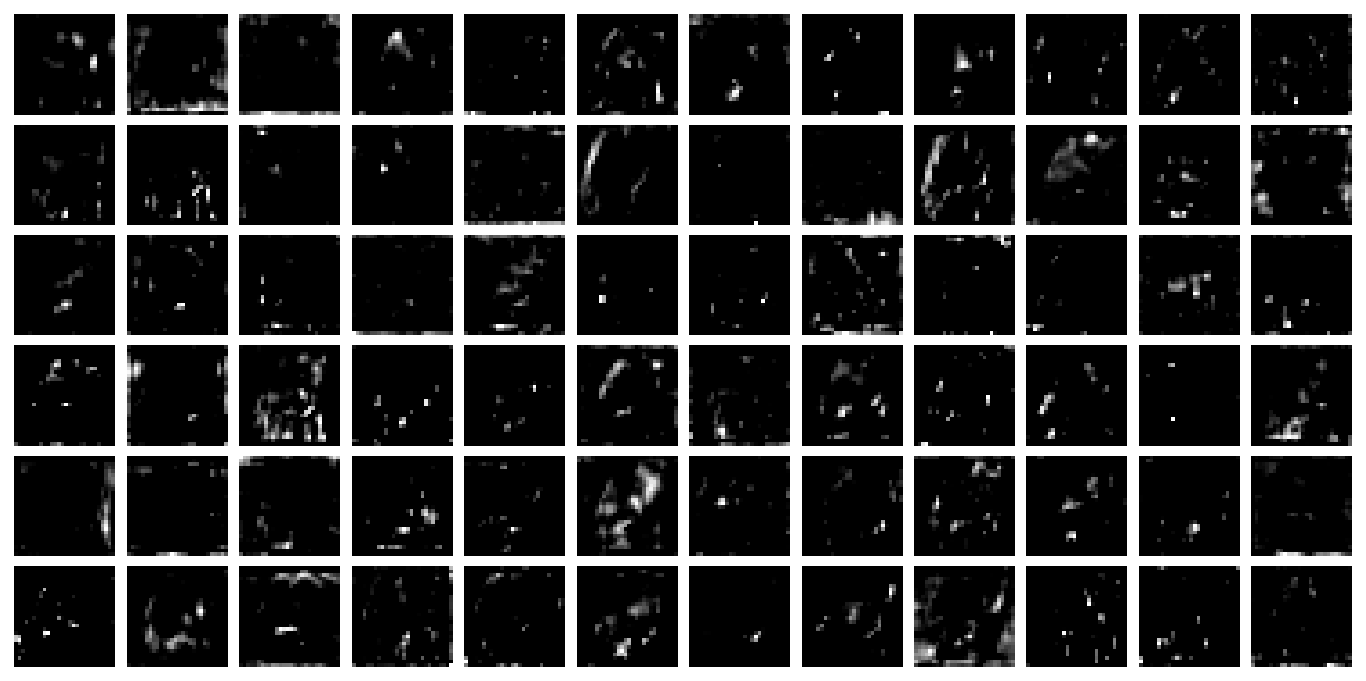

In [11]:
## 对中间层进行可视化,只可视化前72个特征映射
plt.figure(figsize=(12,6))
for ii in range(72):
    ## 可视化每张手写体
    plt.subplot(6,12,ii+1)
    plt.imshow(layer21_conv.data.numpy()[0,ii,:,:],cmap="gray")
    plt.axis("off")
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

### 使用预训练好的VGG16网络对图像进行预测。



In [12]:
## 获取vgg模型训练时对应的1000类的类别标签
LABELS_URL = "https://s3.amazonaws.com/outcome-blog/imagenet/labels.json"
# 从网页链接中获取类别标签
response = requests.get(LABELS_URL)  
labels = {int(key): value for key, value in response.json().items()}

In [13]:
## 使用VGG16网络预测图像的种类
vgg16.eval()
im_pre = vgg16(input_im)
## 计算预测top-5的可能性
softmax = nn.Softmax(dim=1)
im_pre_prob = softmax(im_pre)
prob,prelab = torch.topk(im_pre_prob,5)
prob = prob.data.numpy().flatten()
prelab = prelab.numpy().flatten()
for ii,lab in enumerate(prelab):
    print("index: ", lab ," label: ",labels[lab]," ||",prob[ii])

index:  101  label:  tusker  || 0.48892713
index:  385  label:  Indian elephant, Elephas maximus  || 0.35237467
index:  386  label:  African elephant, Loxodonta africana  || 0.15866028
index:  346  label:  water buffalo, water ox, Asiatic buffalo, Bubalus bubalis  || 2.2302525e-05
index:  345  label:  ox  || 3.4414245e-06


In [14]:
# African elephant 非洲大象
# tusker 长牙动物
# Indian elephant 印度象，亚洲象属maximus
# water buffalo 水牛
# Weimaraner 威马

### 可视化图像的类激活热力图 Grad-CAM


In [15]:
## 定义一个萌购输出最后的卷机层输出和梯度的新的网络
class MyVgg16(nn.Module):
    def __init__(self):
        super(MyVgg16, self).__init__()
        
        # 使用预训练好的VGG16模型
        self.vgg = models.vgg16(pretrained=True)
        # 切分vgg6模型，便于获取卷积层的输出
        self.features_conv = self.vgg.features[:30]
        # 使用原始的最大值池化层
        self.max_pool = self.vgg.features[30]
        self.avgpool = self.vgg.avgpool
        # 使用vgg16的分类层
        self.classifier = self.vgg.classifier
        # 生成梯度占位符
        self.gradients = None
    
    # 获取地图的钩子函数
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        # 注册钩子
        h = x.register_hook(self.activations_hook)
        # 对卷积后的输出使用最大值池化
        x = self.max_pool(x)
        x = self.avgpool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # 获取梯度的方法
    def get_activations_gradient(self):
        return self.gradients
    
    # 获取卷机层输出的方法
    def get_activations(self, x):
        return self.features_conv(x)

In [16]:
# 初始化网络
vggcam = MyVgg16()
# 设置网络的模式
vggcam.eval()
## 计算网络对图像的预测值
im_pre = vggcam(input_im)
## 计算预测top-5的可能性
softmax = nn.Softmax(dim=1)
im_pre_prob = softmax(im_pre)
prob,prelab = torch.topk(im_pre_prob,5)
prob = prob.data.numpy().flatten()
prelab = prelab.numpy().flatten()
for ii,lab in enumerate(prelab):
    print("index: ", lab ," label: ",labels[lab]," ||",prob[ii])
    
## 这里预测结果和前面的一样，可能性最大的是第101个编号


index:  101  label:  tusker  || 0.48892713
index:  385  label:  Indian elephant, Elephas maximus  || 0.35237467
index:  386  label:  African elephant, Loxodonta africana  || 0.15866028
index:  346  label:  water buffalo, water ox, Asiatic buffalo, Bubalus bubalis  || 2.2302525e-05
index:  345  label:  ox  || 3.4414245e-06


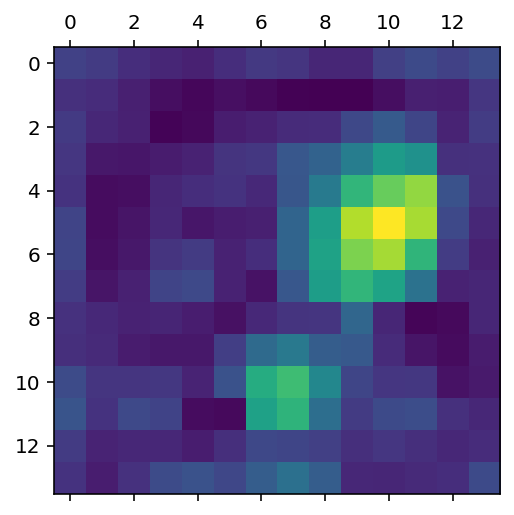

In [17]:
# 获取相对于模型参数的输出梯度
im_pre[:, prelab[0]].backward()
# 获取模型的梯度
gradients = vggcam.get_activations_gradient()
# 计算梯度相应通道的均值
mean_gradients = torch.mean(gradients, dim=[0, 2, 3])
# 获取图像在相应卷积层输出的卷积特征
activations = vggcam.get_activations(input_im).detach()
# m每个通道乘以相应的梯度均值
for i in range(len(mean_gradients)):
    activations[:, i, :, :] *= mean_gradients[i]    
# 计算所有通道的均值输出得到热力图
heatmap = torch.mean(activations, dim=1).squeeze()
# 使用relu函数作用于热力图
heatmap = F.relu(heatmap)
# 对热力图进行标准化
heatmap /= torch.max(heatmap)
heatmap = heatmap.numpy()
# 可视化热力图
plt.matshow(heatmap)

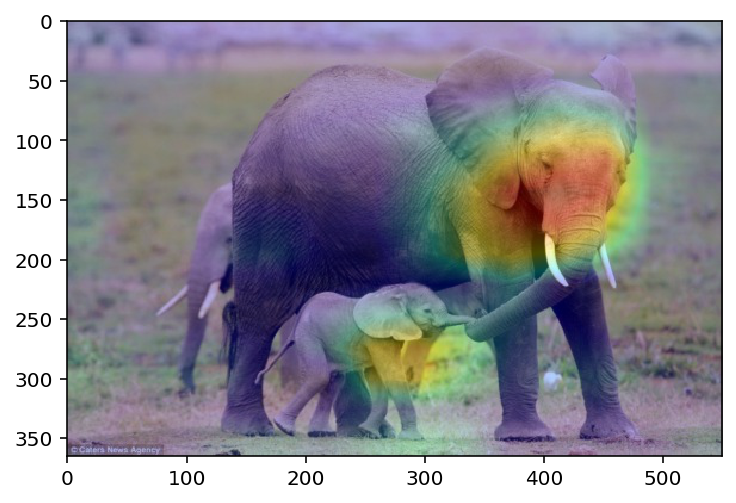

In [18]:
## 将Grad－CAM热力图融合到原始图像上
img = cv2.imread("data/chap6/大象.jpg")
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
Grad_cam_img = heatmap * 0.4 + img
Grad_cam_img = Grad_cam_img / Grad_cam_img.max()
## 可视化图像
b,g,r = cv2.split(Grad_cam_img)
Grad_cam_img = cv2.merge([r,g,b])
plt.figure()
plt.imshow(Grad_cam_img)
plt.show()

index:  292  label:  tiger, Panthera tigris  || 0.9557159
index:  282  label:  tiger cat  || 0.04336377
index:  340  label:  zebra  || 0.00084824767
index:  290  label:  jaguar, panther, Panthera onca, Felis onca  || 2.3158935e-05
index:  281  label:  tabby, tabby cat  || 4.2879533e-06


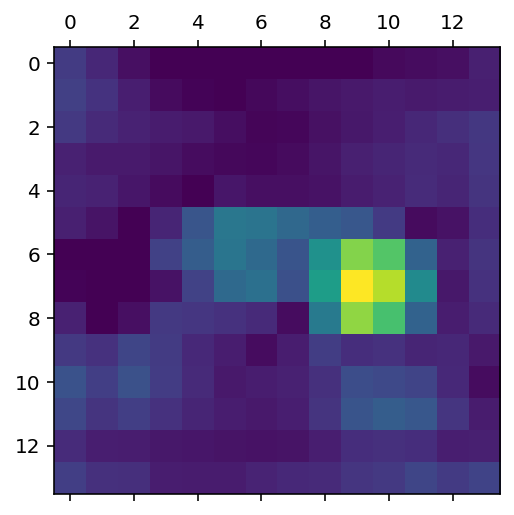

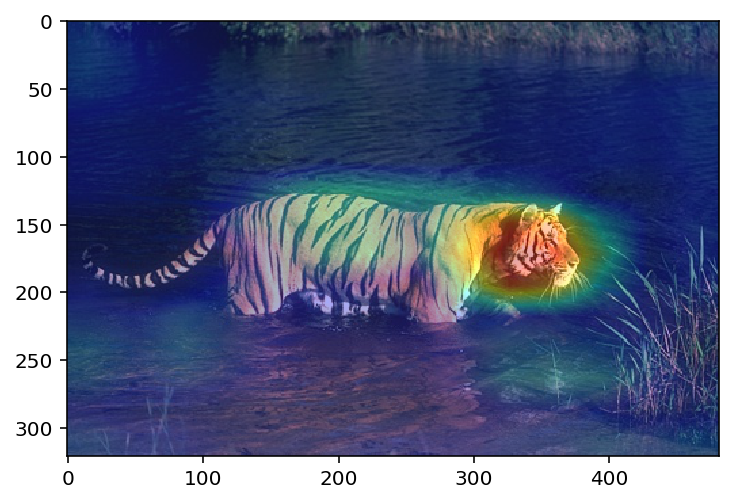

In [19]:
## 可视化老虎图像的Grad－cam
im = Image.open("data/chap6/老虎.jpg")
input_im = data_transforms(im).unsqueeze(0)

# 初始化网络
vggcam = MyVgg16()
# 设置网络的模式
vggcam.eval()
## 计算网络对图像的预测值
im_pre = vggcam(input_im)
## 计算预测top-5的可能性
softmax = nn.Softmax(dim=1)
im_pre_prob = softmax(im_pre)
prob,prelab = torch.topk(im_pre_prob,5)
prob = prob.data.numpy().flatten()
prelab = prelab.numpy().flatten()
for ii,lab in enumerate(prelab):
    print("index: ", lab ," label: ",labels[lab]," ||",prob[ii])
    

# 获取相对于模型参数的输出梯度
im_pre[:, prelab[0]].backward()
# 获取模型的梯度
gradients = vggcam.get_activations_gradient()
# 计算梯度相应通道的均值
mean_gradients = torch.mean(gradients, dim=[0, 2, 3])
# 获取图像在相应卷积层输出的卷积特征
activations = vggcam.get_activations(input_im).detach()
# m每个通道乘以相应的梯度均值
for i in range(len(mean_gradients)):
    activations[:, i, :, :] *= mean_gradients[i]    
# 计算所有通道的均值输出得到热力图
heatmap = torch.mean(activations, dim=1).squeeze()
# 使用relu函数作用于热力图
heatmap = F.relu(heatmap)
# 对热力图进行标准化
heatmap /= torch.max(heatmap)
heatmap = heatmap.numpy()
# 可视化热力图
plt.matshow(heatmap)


## 将Grad－CAM热力图融合到原始图像上
img = cv2.imread("data/chap6/老虎.jpg")
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
Grad_cam_img = heatmap * 0.5 + img
Grad_cam_img = Grad_cam_img / Grad_cam_img.max()
## 可视化图像
b,g,r = cv2.split(Grad_cam_img)
Grad_cam_img = cv2.merge([r,g,b])
plt.figure()
plt.imshow(Grad_cam_img)
plt.show()